In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = '/content/drive/MyDrive/Colab Notebooks/data2010_Seoul.csv'
df = pd.read_csv(dataset_filepath, index_col='date', parse_dates=True)
ts = df['cardio']  
print(type(ts))
ts.head()


<class 'pandas.core.series.Series'>


date
2000-01-01    30
2000-01-02    34
2000-01-03    41
2000-01-04    37
2000-01-05    42
Name: cardio, dtype: int64

# 1 시계열 데이터 준비하기
칼럼 종류: date, nonacc, cardio, respir, meanpm10, meanso2, meanno2, meantemp, meanhumi, meanpress, season, dow, sn이 저장되어 있는 것을 확인할 수 있다.
이번 분석에선 cardio(심장 질환)만 사용하겠다.  

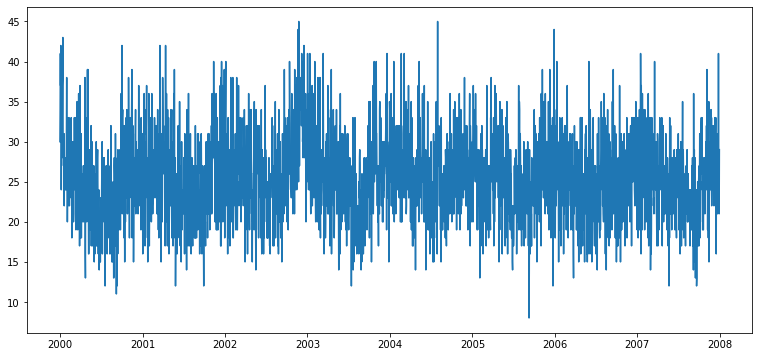

In [44]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 준다.

# 시계열(time series) 데이터를 차트로 그려 보기
plt.plot(ts)

In [45]:
# 결측치 처리 => 결측치가 없음
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 


Series([], Name: cardio, dtype: int64)

Series([], Name: cardio, dtype: int64)


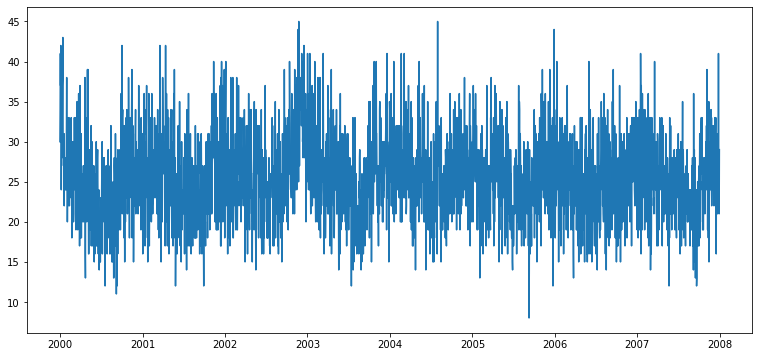

In [46]:
# 결측치가 있다면 이를 보간한다. 보간 기준은 time을 선택한다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인하기
print(ts[ts.isna()])

# 다시 그래프를 확인!
plt.plot(ts)

결측치가 없어 처음 그린 결과와 동일하게 나옴을 알 수 있다

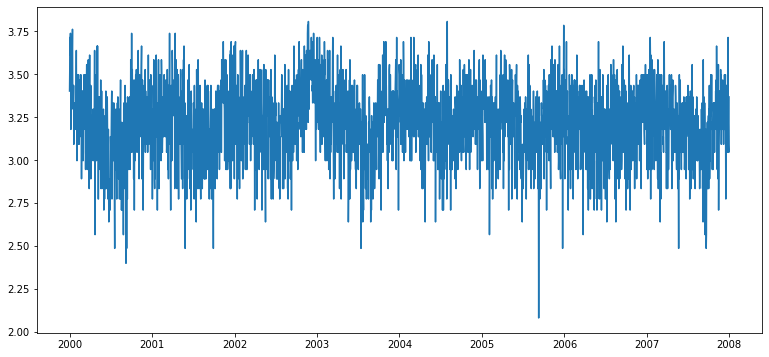

In [47]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

원 데이터의 경우 심장관련 질환 발생 건수가 10-40건 정도 됨을 알 수 있다. 발생건수에 대한 로그 변환 후에는 2.0-3.75의 분포를 보이고 있고 월별 발생량이 거의 규칙적으로 변동하고 있음을 알 수 있다.

In [111]:
ts_log.dropna(inplace = True)
ts_log.head(15)

date
2000-01-01    3.401197
2000-01-02    3.526361
2000-01-03    3.713572
2000-01-04    3.610918
2000-01-05    3.737670
2000-01-06    3.637586
2000-01-07    3.178054
2000-01-08    3.401197
2000-01-09    3.401197
2000-01-10    3.332205
2000-01-11    3.433987
2000-01-12    3.610918
2000-01-13    3.637586
2000-01-14    3.761200
2000-01-15    3.401197
Name: cardio, dtype: float64

STEP 3 : 시계열 안정성 분석¶
정성적 그래프 분석 정량적 Augmented Dicky-Fuller Test 시계열 분해(Time Series Decomposition) Residual 안정성 확인

Moving average 제거 - 추세(Trend) 상쇄하기¶
시계열 분석에서 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 한다. 이 변화량을 제거해 주기 위해 Moving Average, rolling mean을 구해서 ts_log에서 빼준다.

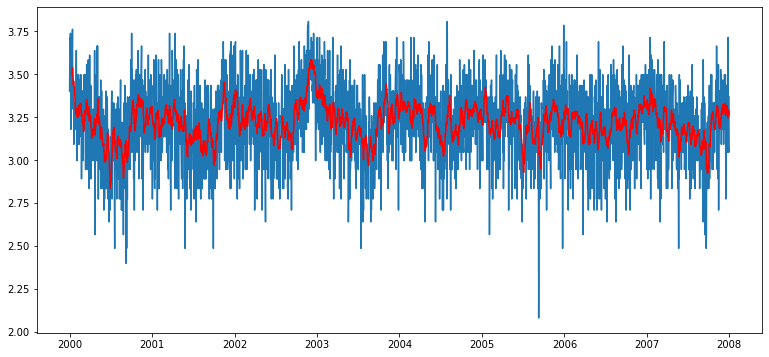

In [112]:
moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [113]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

date
2000-01-01         NaN
2000-01-02         NaN
2000-01-03         NaN
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-08         NaN
2000-01-09         NaN
2000-01-10         NaN
2000-01-11         NaN
2000-01-12    0.112179
2000-01-13    0.119149
2000-01-14    0.223193
2000-01-15   -0.110779
Name: cardio, dtype: float64

Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다. 이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시키므로 데이터셋에서 제거해 준다.

In [114]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

date
2000-01-12    0.112179
2000-01-13    0.119149
2000-01-14    0.223193
2000-01-15   -0.110779
2000-01-16   -0.063245
2000-01-17   -0.164576
2000-01-18   -0.070593
2000-01-19   -0.025229
2000-01-20   -0.342328
2000-01-21   -0.095416
2000-01-22   -0.128753
2000-01-23   -0.083904
2000-01-24   -0.094014
2000-01-25   -0.100131
2000-01-26   -0.131578
Name: cardio, dtype: float64

In [115]:
# 이동평균구하기
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


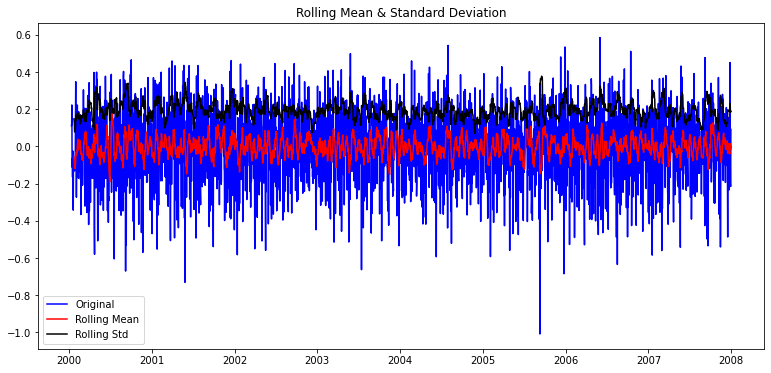

In [116]:
plot_rolling_statistics(ts_log_moving_avg)

 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화한 결과를 보면 원본 시계열보다 이동평균과 이동표준편차가 더 좁은 범위에 분포하는 것을 볼 수 있다. 

In [54]:
# tatsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출하기
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력하기
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
print('슝=3')

슝=3


In [55]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -1.423898e+01
p-value                        1.549451e-26
#Lags Used                     2.700000e+01
Number of Observations Used    2.883000e+03
Critical Value (1%)           -3.432620e+00
Critical Value (5%)           -2.862543e+00
Critical Value (10%)          -2.567304e+00
dtype: float64


p-value가 1.549451e-26 로 엄청 작은 값이 나옴을 알 수 있다. 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있다.

시프트한 시계열과 원본 시계열에 대한 그래프를 그려보기

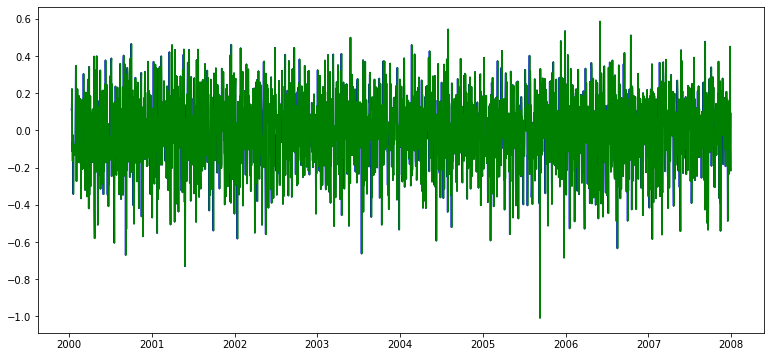

In [117]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현

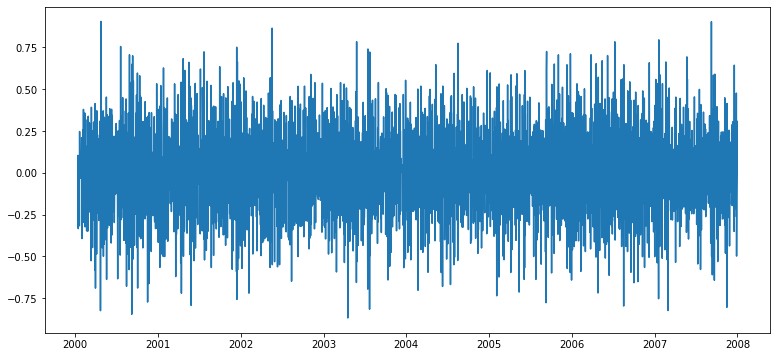

In [118]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악해보기

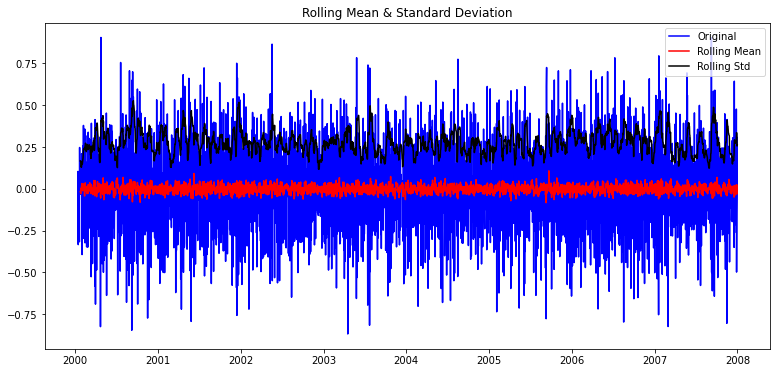

In [119]:
plot_rolling_statistics(ts_log_moving_avg_diff)

차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행해 보기

In [59]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -19.691521
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    2882.000000
Critical Value (1%)              -3.432621
Critical Value (5%)              -2.862543
Critical Value (10%)             -2.567304
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가 1차 차분(1st order differencing)을 적용하여 Seasonality 효과를  상쇄한 결과, p-value가 1.716087e-28이 되었다. 

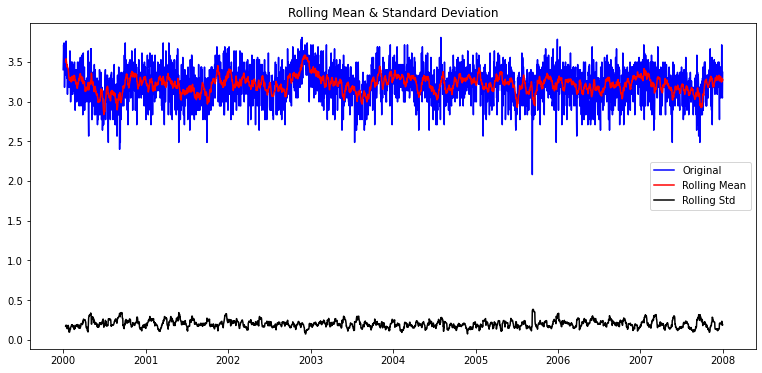

Results of Dickey-Fuller Test:
Test Statistic                -6.643179e+00
p-value                        5.346041e-09
#Lags Used                     2.100000e+01
Number of Observations Used    2.900000e+03
Critical Value (1%)           -3.432607e+00
Critical Value (5%)           -2.862537e+00
Critical Value (10%)          -2.567301e+00
dtype: float64


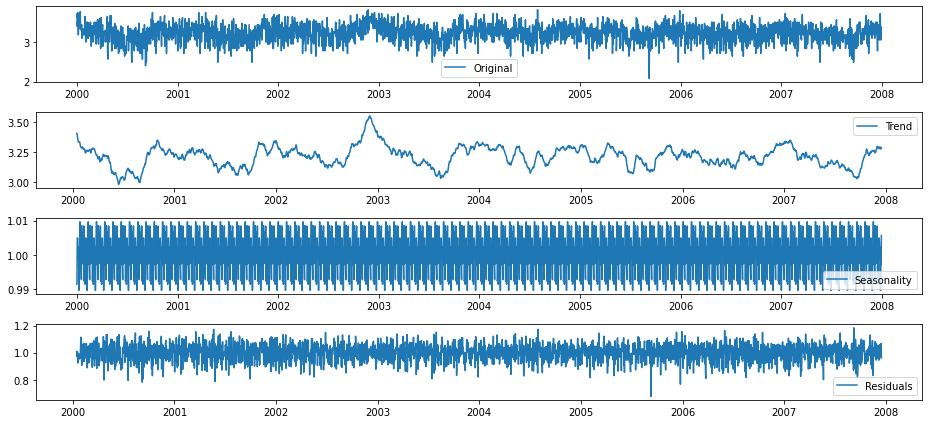

In [121]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

안정적 시계열 특징은 시간의 추이와 관계 없이 평균이 불변, 시간의 추이와 관계 없이 분산이 불변, 두 시점 간의 공분산이 기준시점과 무관해야 한다. 여기에선 평균과 분산이 거의 일정한 패턴을 보이고 있으므로 이 시계열 데이터는 안정적이라고 정성적 결론을 내릴 수 있을 것 같다.
그런데 정량적인 분석 결과 p-value : 0.590149 > 0.05로 귀무가설을 채택해야 하는 상황이 되었다. p-value가 0.6에 가깝다는 것이 이 귀무가설(주어진 시계열 데이터가 안정적이지 않다.)이 옳다는 직접적인 증거는 아니다. 하지만 귀무가설을 기각할 수 없게 되었으므로 안정적 시계열이라고 볼 수는 없다.¶
시계열 분해 수행 : Trend + Seasonlity + Residual = Original 이 성립하며 시계열 데이터 이해하는 중요한 관점을 제시해준다

3-4 Residual 안정성 확인

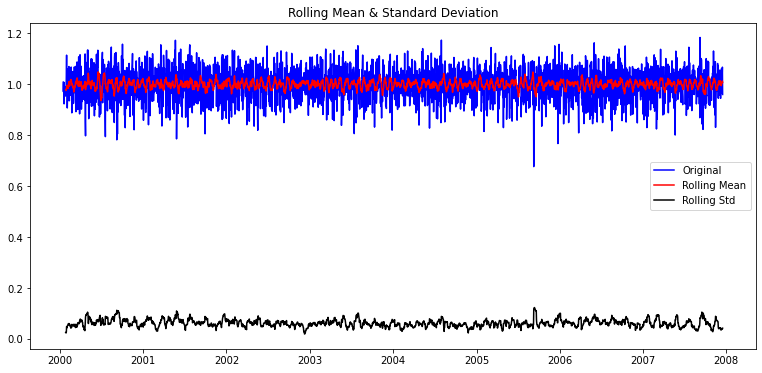

In [122]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [123]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.749174e+01
p-value                        4.433133e-30
#Lags Used                     2.700000e+01
Number of Observations Used    2.864000e+03
Critical Value (1%)           -3.432635e+00
Critical Value (5%)           -2.862550e+00
Critical Value (10%)          -2.567307e+00
dtype: float64


Decomposing을 통해 얻어진 Residual의 p-value : 4.433133e-30 < 0.05 이므로 귀무가설을 채택, 대립가설을 기각한다. 데이타 Residual의 안정성을 확인할 수 있다.

STEP 4 : 학습, 테스트 데이터셋 생성¶
학습, 테스트 데이터셋 분리

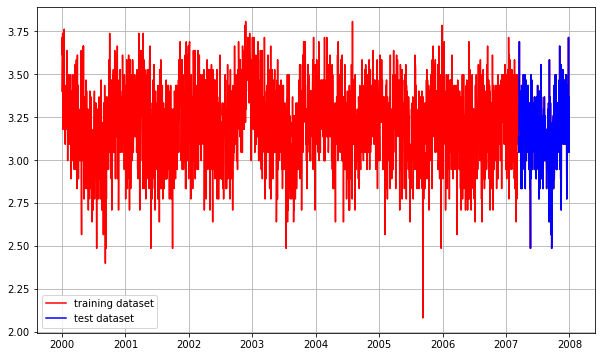

In [124]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


STEP 5 : 적정 ARIMA 모수 찾기¶
ACF, PACF 그려보기 -> p,q 구하기 차분 안정성 확인 -> d 구하기

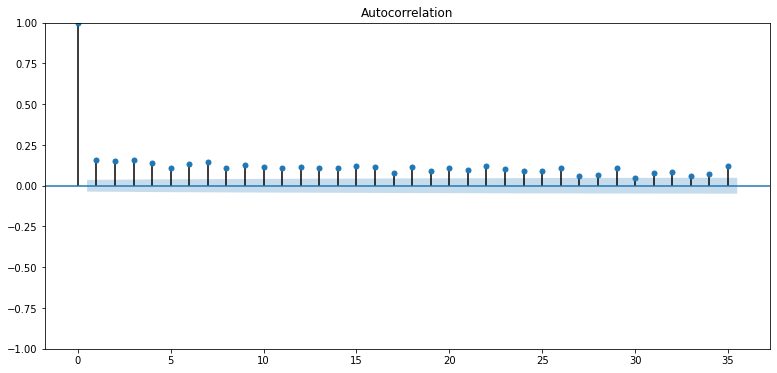

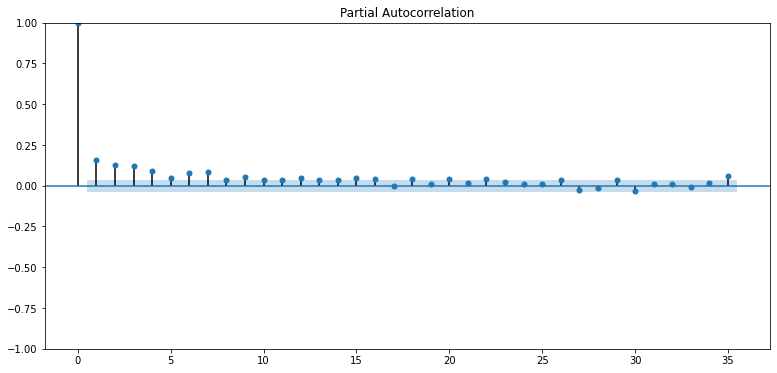

In [125]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


PACF 그래프를 볼 때 p=1이 매우 적합한 것 같다. p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문다. PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.¶
ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있다. q에 대해서는 적합한 값이 없어 보인다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있다.

Results of Dickey-Fuller Test:
Test Statistic                -1.597386e+01
p-value                        6.955890e-29
#Lags Used                     2.700000e+01
Number of Observations Used    2.893000e+03
Critical Value (1%)           -3.432612e+00
Critical Value (5%)           -2.862540e+00
Critical Value (10%)          -2.567302e+00
dtype: float64


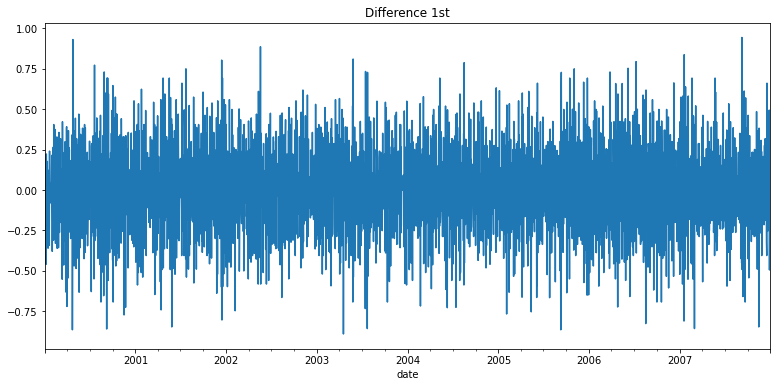

In [126]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                  -22.444242
p-value                           0.000000
#Lags Used                       28.000000
Number of Observations Used    2891.000000
Critical Value (1%)              -3.432614
Critical Value (5%)              -2.862540
Critical Value (10%)             -2.567302
dtype: float64


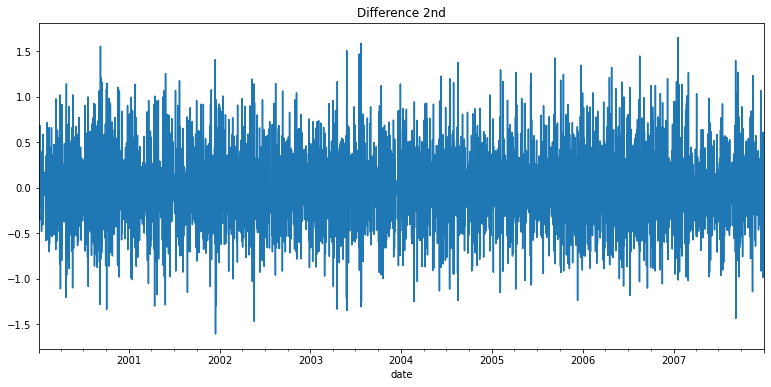

In [127]:

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

1차 차분에서 p-value : 6.9558902e-29 < 0.05, 2차 차분 결과 p-value : 0.0000000 < 0.05를 보인 것으로 보아 확실히 안정화 상태라고 볼 수 있다.

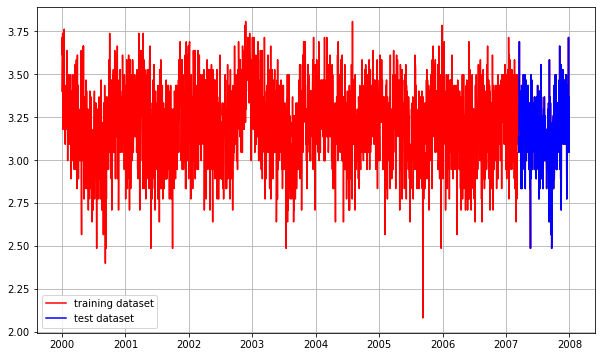

In [128]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


tes_data도 train_data와 비슷한 형태의 양상을 보임을 알 수 있다.

In [68]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

date
2000-01-01    3.401197
2000-01-02    3.526361
Name: cardio, dtype: float64
(2629,)
(293,)


STEP 6 : ARIMA 모델 훈련과 테스트
ARIMA 모델 빌드와 훈련¶
모델 테스트 및 플로팅
최종 예측 모델 정확도 측정(MAPE)

쥬피터 노트북은 환경설정이 다 되어 있는데 구글코랩은 설정이 되지 않아 에러가 발생하는 곳이 여러 곳이 있다. 이부분은 statsmodels을 불러오는 과정이다. 

In [69]:
!pip install statsmodels

order에 들어가는 (p, d, q) 값을 알아보는 방법 중 자동으로 선택하는 방법을 시도해보았다. p : 자기회귀 모형(AR)의 시차
d : 차분 누적(I) 횟수
q : 이동평균 모형(MA)의 시차
max값을 지정하지 않았을 경우 5로 되는 데 이때 MAPE값이 크게 나와서 15로 수정하고 진행함.
계절성을 주기 위해 season에 True로 설정해 주었다. 결과를 보니 best model이(15, 0, 0)로 나옴을 알 수 있다.

In [130]:
# 첫번째 AUTO-ARIMA 모델 훈련하기
import pmdarima as pm
model = pm.auto_arima(train_data, start_p = 0, max_p = 15, start_q = 0, max_q = 15, seasonal = True, trace = True) 
fitted_m=model.fit(train_data)
# model.fit(train_data)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-462.042, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-524.076, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-511.296, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13626.878, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-567.210, Time=0.53 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-608.884, Time=3.17 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-625.669, Time=2.26 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-630.553, Time=7.66 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=-639.870, Time=6.46 sec
 ARIMA(7,0,0)(0,0,0)[0] intercept   : AIC=-657.601, Time=7.62 sec
 ARIMA(8,0,0)(0,0,0)[0] intercept   : AIC=-660.720, Time=9.79 sec
 ARIMA(9,0,0)(0,0,0)[0] intercept   : AIC=-667.919, Time=12.48 sec
 ARIMA(10,0,0)(0,0,0)[0] intercept   : AIC=-669.459, Time=7.69 sec
 ARIMA(11,0,0)(0,0,0)[0] intercept   : AIC=-670.060, Time=17.31 sec
 ARIMA(12,0,0)(0,0,0)[0] int

auto_arima를 수행하는 경우 Forecast가 적용되지 않아 이부분을 predict로 수정하여 실행하였다. 

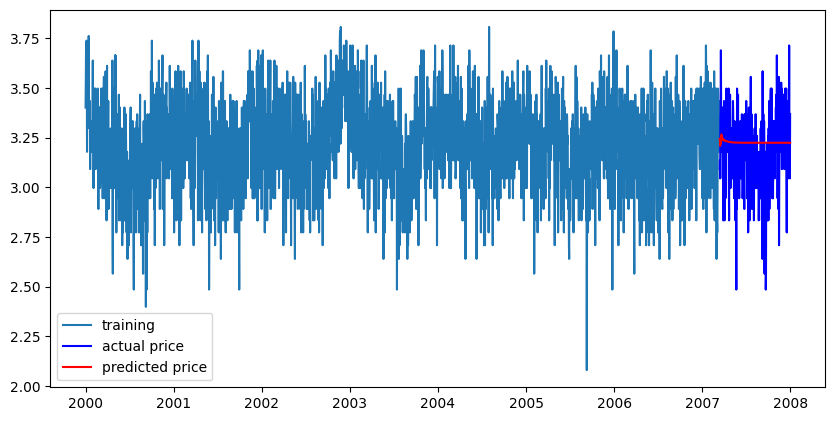

In [131]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.predict(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [132]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  23.280886282081653
MAE:  3.7867740498927707
RMSE:  4.825027075787415
MAPE: 17.14%


auto_arima의 경우 best order(15, 0 , 0)을 수행한 결과 MAPE가 17.14%로 높은 값을 보이고 있다. 모델에 대한 편향이 존재한다고 봐야 할 것 같다. 

In [154]:
# 두번째 ARIMA 모델 훈련하기
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 0, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                 cardio   No. Observations:                 2629
Model:                          ARIMA   Log Likelihood                 233.021
Date:                Thu, 17 Feb 2022   AIC                           -462.042
Time:                        08:29:53   BIC                           -450.294
Sample:                    01-01-2000   HQIC                          -457.788
                         - 03-13-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2219      0.004    723.140      0.000       3.213       3.231
sigma2         0.0490      0.001     37.236      0.000       0.046       0.052
Ljung-Box (L1) (Q):                  63.33   Jarque-

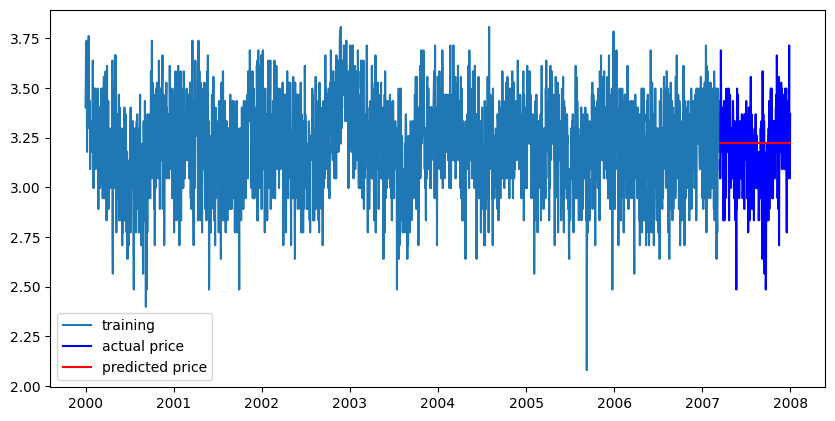

In [155]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [156]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  23.194273376529704
MAE:  3.7676228720771268
RMSE:  4.816043332085967
MAPE: 17.01%


order에 (2, 1, 0) 적용시 MAPE : 22.06% 나옴
order에(2, 0, 0) 적용시 MAPE : 17.02% 나옴
order에 (3, 0, 1) 적용시 MAPE : 17.23% 나옴
order에 (0, 0, 1) 적용시 MAPE : 17.01% 나옴
order에 (0, 0 , 0) 적용시 MAPE : 17.01% 나옴
=> 전체적으로 높은 값을 보이고 있음. 

In [157]:
# 세번째 SARIMA 모델 훈련하기
import warnings
warnings.filterwarnings('ignore') #경고 무시
#from statsmodels.tsa.statespace.arima import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = SARIMAX(train_data,order=(0, 1,1), seasonal_order=(0,1,1,12)) # 모수는 이전 그래프를 참고 
# fitted_m = model.fit() 
fitted_m = model.fit()
print(fitted_m.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             cardio   No. Observations:                 2629
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 318.301
Date:                            Thu, 17 Feb 2022   AIC                           -630.603
Time:                                    08:32:02   BIC                           -612.994
Sample:                                01-01-2000   HQIC                          -624.225
                                     - 03-13-2007                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9357      0.007   -129.632      0.000      -0.950      -0.922
ma.S.L12      -0.9964      0.011   

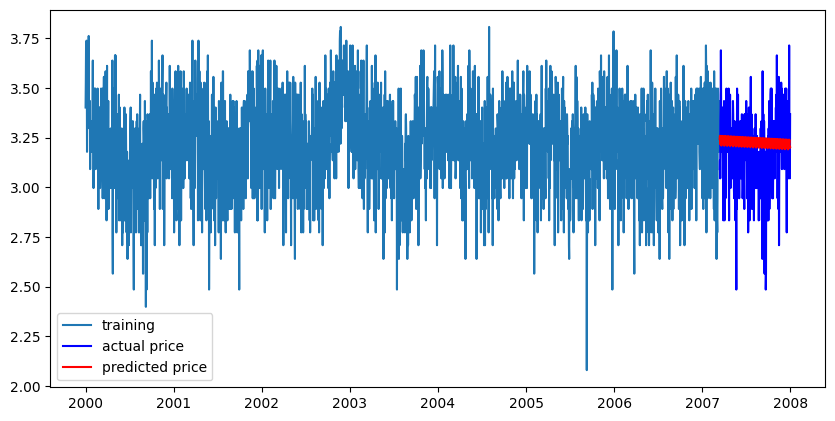

In [158]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [159]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  23.368071684181675
MAE:  3.803911707485957
RMSE:  4.834053338988067
MAPE: 17.21%


order(0, 1, 1), seasonal(0, 1, 1, 12) 인 경우 MAPE : 17.21%의 값을 보임
전체적으로 모델에 대한 편향이 존재한다고 볼 수 있다.
AUTO_ARIMA의 경우를 봐도 MAPE값이 크게 나오는 것을 보면 데이타가 오래된 것에 기인하는 것인지 하는 의문이 든다. 본 자료는 2000-2010년까지 월별 미세먼지와 관련한 질환건수에 대한 자료이다. 과거엔 미세먼지가 건강에 미치는 연구가 지금처럼 세밀하게 진행되지 않아 정확한 진단이 나오지 않았다고 생각된다.

시계열을 R 프로그램을 활용하면서 진행할 때는 내용도 어렵고 실행이 안 되어 고민이 많았는데 파이썬에선 (잘 짜준 코드 덕분에...) 나름 구현이 잘 되어 기뻤다.
쥬피터 노트북 상에서 실행하려고 데이터를 upload하는데 시간이 너무 오래 걸려 구글코랩을 이용하기로 하였는데 처음 불러오는 것 부터 난관에 봉착하고 라이브러리 등이 없는 것이 있어 새로 깔고 설정하는 과정에서 많은 것을 배웠다. 오늘도 경은퍼실님의 도움에 감사를 드린다.